In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [4]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
nev                    = 10        # which Eigenvector to choose
ϵ                      = 10       # perturbation
t₀                      = 0.6      # parameter value corresponding to ϵ=0
wind_scale             = 1e-3
wind_center            = 0
solver_tolerance       = 1e-6
solver                 = OrdinaryDiffEq.BS5();

In [5]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end;

In [6]:
gyre_wind(param) = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> rot_double_gyre(u,p,t) + param*wind_scale*[u[2]-wind_center, 0])

gyre_wind (generic function with 1 method)

In [7]:
T(x,p) = flow(gyre_wind(p), x, [0.0, t₀],
    tolerance = solver_tolerance, solver = solver)[end];

In [8]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [9]:
M = assembleMassMatrix(ctx);

In [10]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

172.615568 seconds (1.29 G allocations: 56.074 GiB, 6.02% gc time)


In [11]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ);

In [12]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

450.985499 seconds (2.80 G allocations: 236.605 GiB, 8.42% gc time)


In [13]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  3.605078 seconds (9.33 M allocations: 534.501 MiB, 4.88% gc time)


In [14]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [15]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  1.492900 seconds (4.35 M allocations: 247.556 MiB, 4.62% gc time)
  0.061882 seconds (292 allocations: 36.363 MiB)
  0.065923 seconds (292 allocations: 36.363 MiB)
  0.112338 seconds (65.91 k allocations: 39.997 MiB, 27.57% gc time)
  0.061899 seconds (292 allocations: 36.363 MiB)
  0.062212 seconds (292 allocations: 36.363 MiB)
  0.064478 seconds (292 allocations: 36.363 MiB)
  0.077197 seconds (300 allocations: 36.364 MiB, 17.69% gc time)
  0.060384 seconds (292 allocations: 36.363 MiB)
  0.062117 seconds (292 allocations: 36.363 MiB)


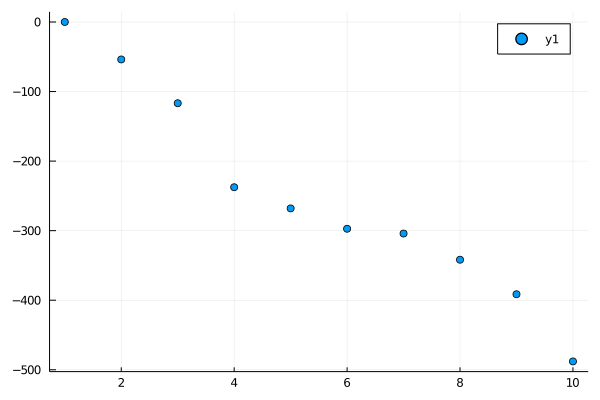

In [16]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [17]:
nev = 3
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [18]:
for i in 1:nev
    print("exact ev"*string(i)*": "*string(λϵ[i])*
        "\t predicted ev"*string(i)*": "*string(λ₀[i] + ϵ*λ_dot[i])*
        "\t relative error: "*string(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]))*"\n")
end

exact ev1: 2.3084086880204195e-8	 predicted ev1: -4.3062236814830276e-10	 relative error: 1.0186545116721764
exact ev2: -55.07691365151724	 predicted ev2: -55.76288326607664	 relative error: 0.012454757703012784
exact ev3: -116.93149090425717	 predicted ev3: -116.94369764703757	 relative error: 0.00010439226153703537


In [23]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmins =     [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5]
cmaxs =     -cmins
cmins_lr =  [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01]
cmaxs_lr =  -cmins_lr;

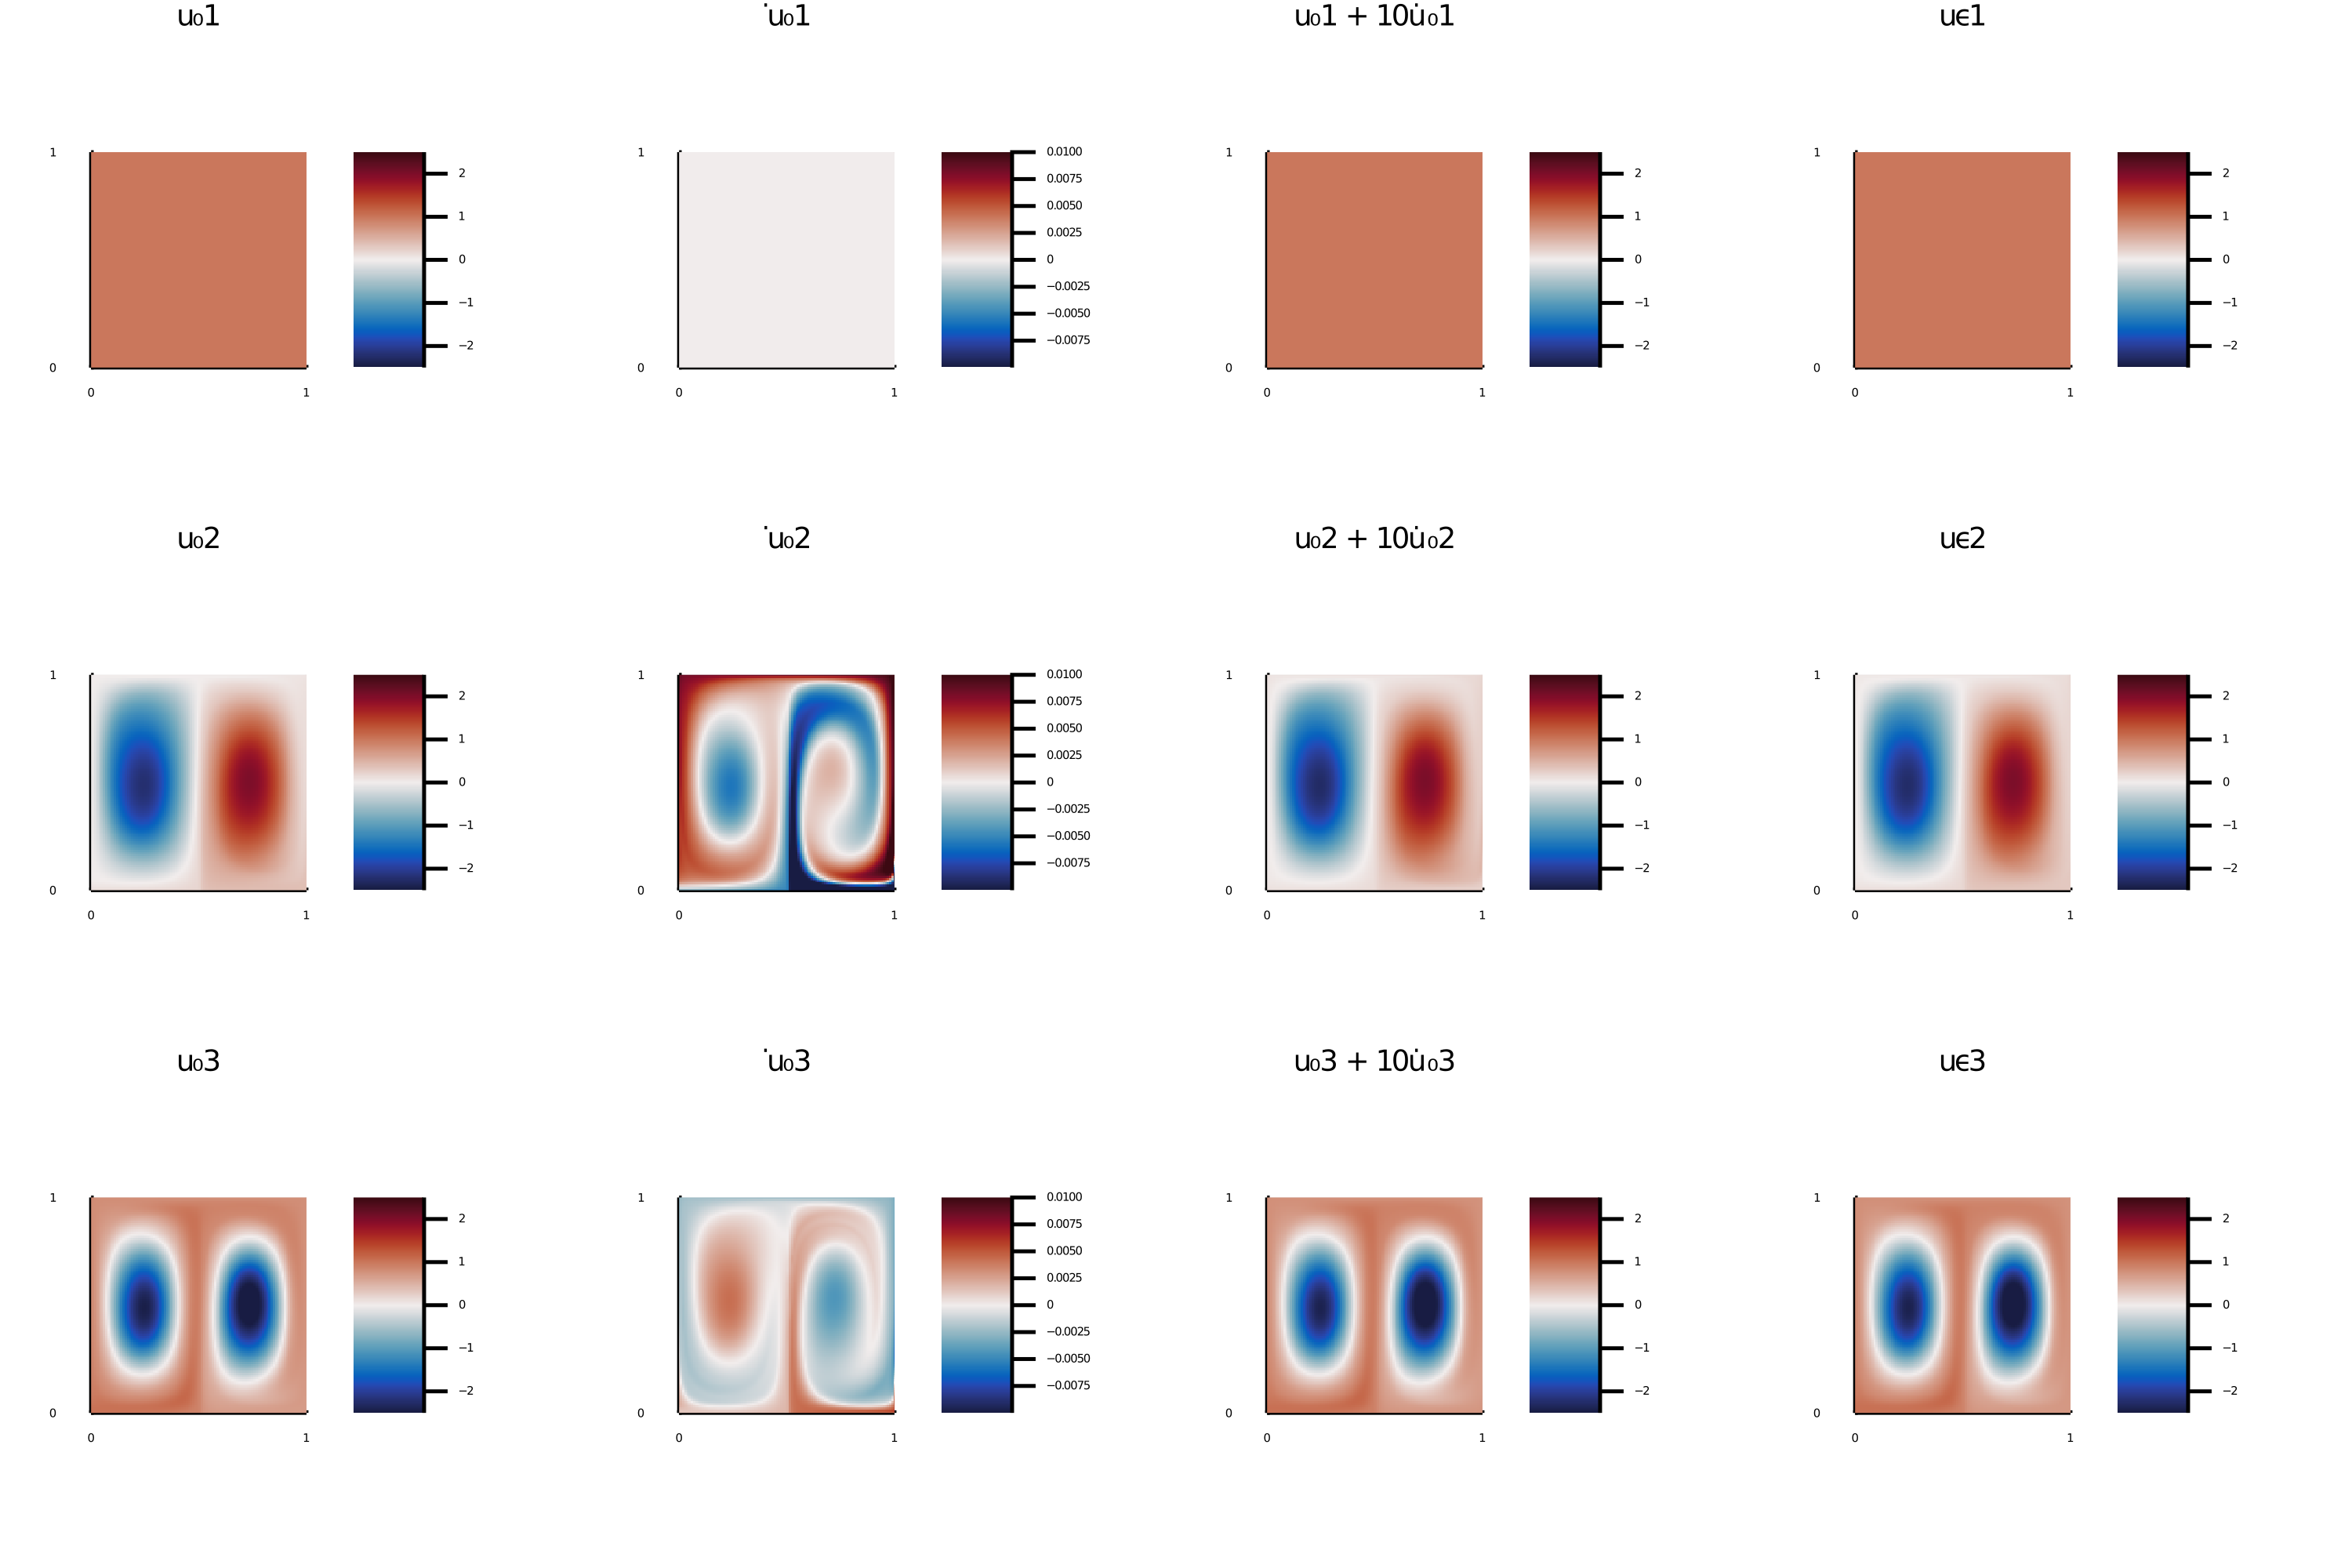

In [24]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  grid_resolution, grid_resolution, 
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  grid_resolution, grid_resolution, 
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  grid_resolution, grid_resolution, 
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  grid_resolution, grid_resolution, 
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [25]:
#limit ourselves to one ev for plotting etc.
ev = 2

2

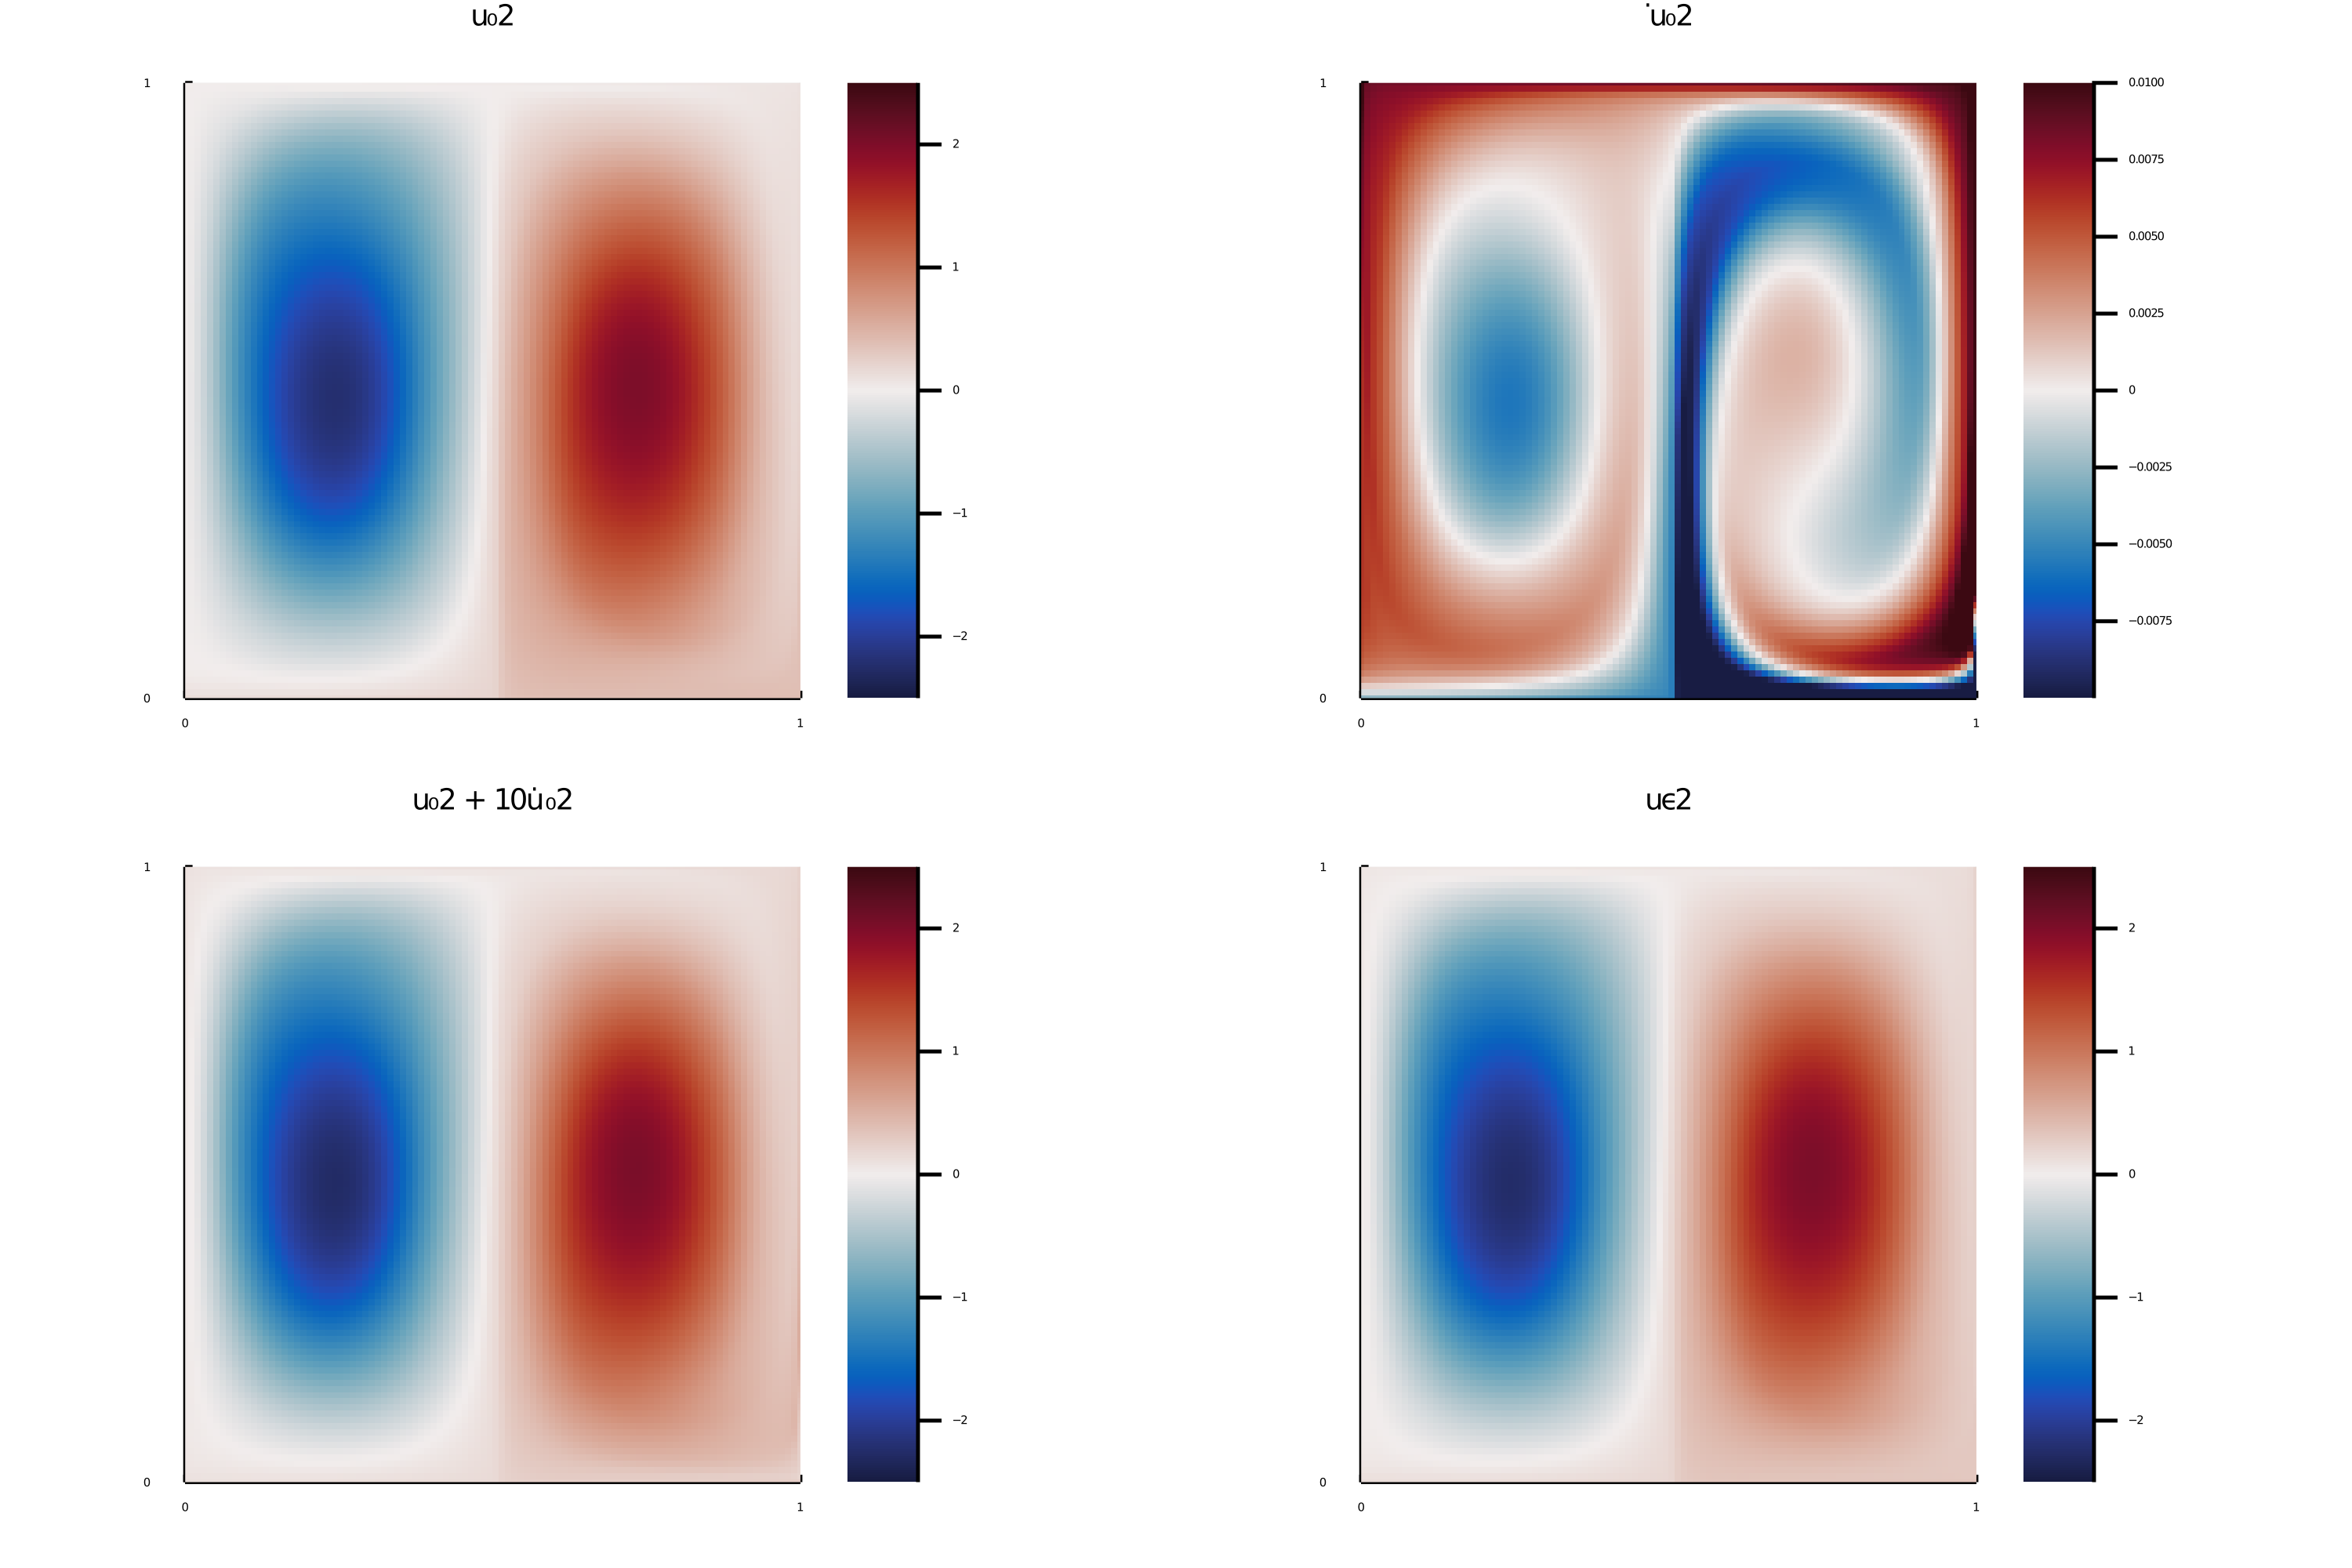

In [26]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="̇u₀"*string(ev), 
    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  grid_resolution, grid_resolution, 
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [27]:
using Contour

In [28]:
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)

dynamic_cheeger_value (generic function with 2 methods)

In [29]:
# resoultion for the levelset methods (default should be 'nothing', that way the grid resolution is used)
x_resolution = 500
y_resolution = 500;

In [30]:
minU = minimum(u₀[:,ev])
maxU = maximum(u₀[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,x_resolution=x_resolution,y_resolution=y_resolution)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.006709992129675961)
└ @ Main In[30]:9
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.010959971456237791)
└ @ Main In[30]:9


InterruptException: [91mInterruptException:[39m

In [ ]:
minU = -1
maxU = 1
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,x_resolution=x_resolution,y_resolution=y_resolution)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[1:end],values[1:end])
Plots.plot!(fmt=:png,dpi=100)

In [31]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.008075876731104794)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.010094845913880992)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01211381509665719)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.014132784279433389)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:1

Dynamic Cheeger value:	6.40111383573421
Levelset:		0.0020189691827761985


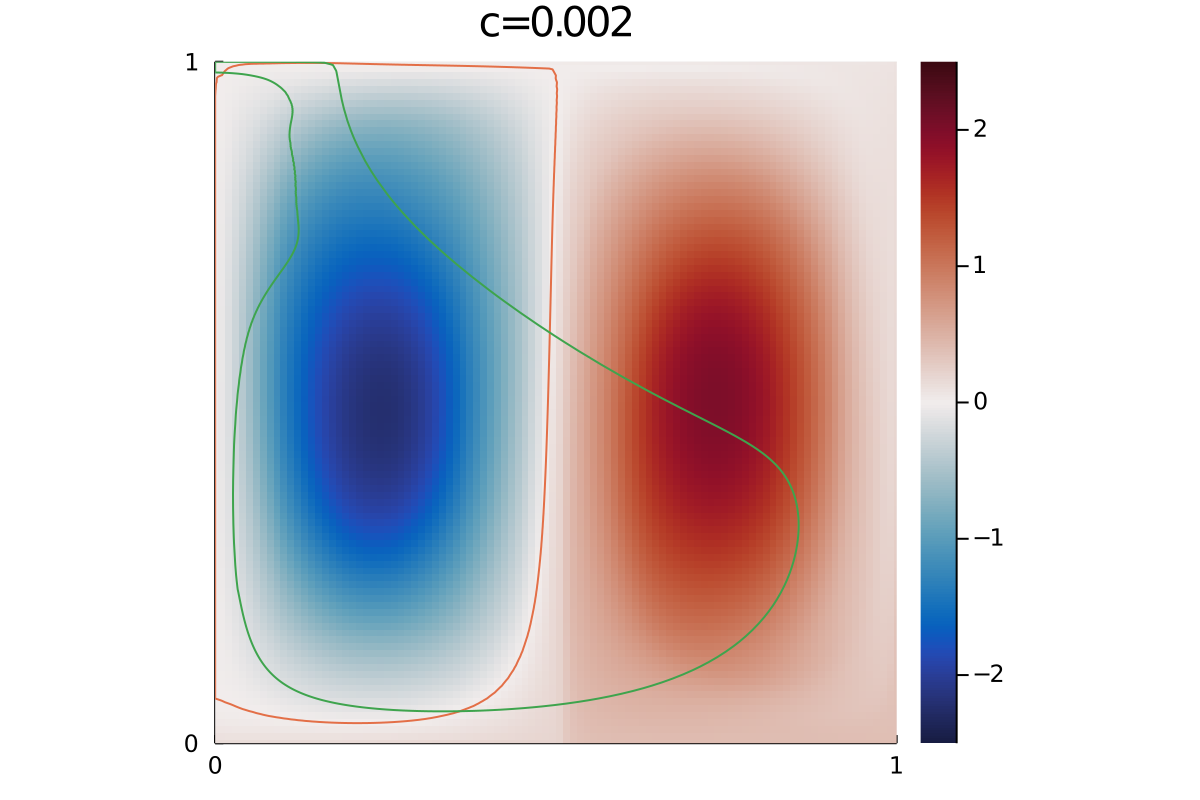

In [32]:
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

In [33]:
using PyCall
using PyPlot

In [34]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

In [43]:
ev = 2

2

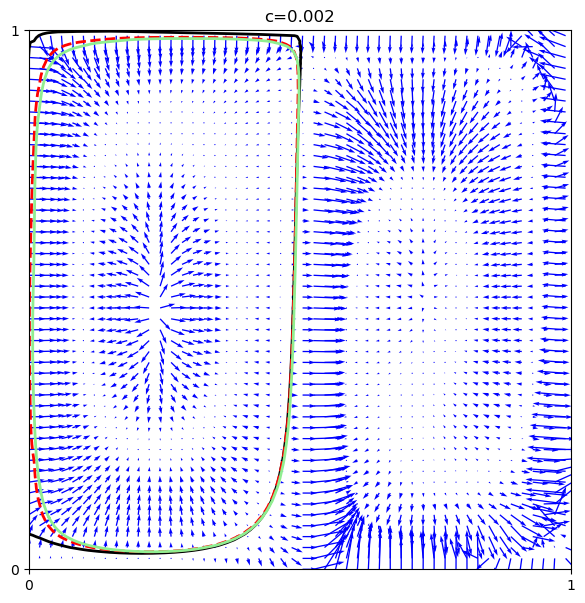

In [44]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev])...,ax,scale=0.2,step=2)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [ ]:
using LinearAlgebra

In [ ]:
# we rescale slightly differently here due to normalizeU instead of normalize
cmins =     [-1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1]
cmaxs =     -cmins
cmins_lr =  [-1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1, -1.1]
cmaxs_lr =  -cmins_lr;

In [ ]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)));

In [ ]:
μ = 0.99/grid_resolution;

In [ ]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

In [ ]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [ ]:
# This is the matrix we effectively multiply u₀ with
Rot = inv(qr(u₀).R)*R'

In [ ]:
S_dot = u_dot*Rot;

In [ ]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [ ]:
S′ = Matrix(qr(u₀).Q)*R';

In [ ]:
Sϵ′ = Matrix(qr(uϵ).Q)*Rϵ';

In [ ]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(S′[:,i]),  
            grid_resolution, grid_resolution, 
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            grid_resolution, grid_resolution, 
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S′[:,i] + ϵ*S_dot[:,i]),  
            grid_resolution, grid_resolution, 
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,i]),  
            grid_resolution, grid_resolution, 
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [ ]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            grid_resolution, grid_resolution, 
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            grid_resolution, grid_resolution, 
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            grid_resolution, grid_resolution, 
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            grid_resolution, grid_resolution, 
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [ ]:
plots = []
push!(plots,plot_u(ctx, normalizeU(S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S′[:,ev] + ϵ*S_dot[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [ ]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [ ]:
minU = minimum(S[:,ev])
maxU = maximum(S[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c,x_resolution=x_resolution,y_resolution=y_resolution)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

In [ ]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

In [ ]:
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

In [ ]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
# this is not completely straightforward due to the nonlinearity of softThreshold!
plot_vectorfield(get_levelset_evolution(ctx,normalizeU(S′[:,ev]),S_dot[:,ev])...,ax,scale=0.2,step=4)
curves           = lines(get_levelset(ctx, S[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best,x_resolution=x_resolution,y_resolution=y_resolution))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),
                         c_best,x_resolution=x_resolution,y_resolution=y_resolution))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

In [ ]:
plot_u(ctx, S[:,ev],  grid_resolution, grid_resolution, title="μ=$(round(μ,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(Main.CoherentStructures.get_levelset(ctx,S′[:,ev],μ,
        x_resolution=x_resolution,y_resolution=y_resolution))
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value_matlab(curves[1])

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

In [ ]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,S′[:,ev],S_dot[:,ev])...,ax,scale=0.2,step=4)
curves           = lines(get_levelset(ctx, S′[:,ev],μ,x_resolution=x_resolution,y_resolution=y_resolution))
curves_epsilon   = lines(get_levelset(ctx, Sϵ′[:,ev],μ,x_resolution=x_resolution,y_resolution=y_resolution))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),
                         μ,x_resolution=x_resolution,y_resolution=y_resolution))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");